# Loading the training set
I use UAM Dataset including 80,000 Faces and their true ages as training set. This dataset hase been created by union of UTKFACE, AgeDB, MegaAge  

## Loading labels of the training set


In [1]:
import numpy as np
y_train_PATH = "../../Datasets/UAM/dist/UAM_dist.txt"
y_train = np.loadtxt(y_train_PATH, delimiter=' ')
y_train.shape

(80174, 101)

## Data Generator, Data Augmenter & Data Loader

In [2]:
import os
from PIL import Image
from torchvision import io, transforms
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

UAM_PATH = "../../Datasets/UAM/images/"


class DataGenerator(Dataset):
 
    def __init__(self, path, image_size, y, transform):
        self.path = path
        self.images_list = os.listdir(path)
        self.images_list.sort()
        self.image_size = image_size
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img = io.read_image(self.path+self.images_list[idx], mode = io.ImageReadMode.RGB).float()
        img = self.transform(img)
        label = self.y[idx]
        return img, label

image_size = (256,256)
batch_size = 64

augmentation = transforms.Compose([
        transforms.Resize(torch.Size([image_size[0], image_size[1]])),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_dataset = DataGenerator(path=UAM_PATH, image_size = image_size, y = y_train, transform=augmentation)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)


# Creating Test sets
I Use whole of FG-NET dataset and 10% of AgeDB to evaluate the model.

In [3]:
from torchvision.io import ImageReadMode
from scipy.special import softmax
FGNET_PATH = '../../Datasets/FGNET/FGNET/images/'
MEGAAGE_TEST_PATH = '../../Datasets/megaage_asian/megaage_asian/'
fgnet_addrs = os.listdir(FGNET_PATH)
X_val = []
Y_val=[]
y_test = []
X_test_megaage = []
y_test_megaage = []

def normal_dist(x , mu , std):
    prob_density = (np.pi*std) * np.exp(-0.5*((x-mu)/std)**2)
    return prob_density

utkface_N = 101 # number of ages in the dataset
sigma = 5

for image_name in os.listdir(FGNET_PATH):
    true_age = int(image_name[4:6])
    generated_numbers = np.random.uniform(1, utkface_N, utkface_N)
    generated_numbers.sort()
    img = io.read_image(FGNET_PATH+image_name, mode = ImageReadMode.RGB).int()
    img = transforms.Resize(torch.Size([image_size[0], image_size[1]]))(img)
    X_val.append(np.array(img))
    Y_val.append(softmax(normal_dist(generated_numbers, true_age, sigma)))
    y_test.append(true_age)
    
X_val, Y_val, y_test = torch.Tensor(X_val), torch.Tensor(Y_val), np.asarray(y_test)

with open(MEGAAGE_TEST_PATH + 'list/test_name.txt', 'r') as f:
    megaage_content = np.array(f.read().split('\n')[:-1])

with open(MEGAAGE_TEST_PATH + 'list/test_age.txt', 'r') as f:
    megaage_content_age = np.array(list(map(int, f.read().split('\n')[:-1])))

for i in range(len(megaage_content)):
    img = io.read_image(MEGAAGE_TEST_PATH + 'test/' + megaage_content[i], mode = ImageReadMode.RGB).int()
    img = transforms.Resize(torch.Size([image_size[0], image_size[1]]))(img)
    X_test_megaage.append(np.array(img))
    y_test_megaage.append(megaage_content_age[i])

X_test_megaage, y_test_megaage = torch.Tensor(X_test_megaage), np.array(y_test_megaage)


c:\Dev\Python\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)


# ResNet50 Model Pretrained on VGG-Face2

In [4]:
import torch.nn as nn
from torchvision.models import resnet50
import pickle

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def create_model():
  random_seed = 49
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)

  base_model = resnet50()
  with open('resnet50_scratch_weight.pkl','rb') as f:
    obj = f.read()
  weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
  base_model.fc = nn.Linear(2048,8631)
  base_model.load_state_dict(weights)
    
  for param in base_model.parameters():
    param.requires_grad = False

  num_ftrs = base_model.fc.in_features
  base_model.fc = nn.Linear(num_ftrs, 101)
  base_model = base_model.to(device)
  return base_model

# Training Loop
train(model, loss_fn, optimizer) is the main function to train the models. 

In [5]:
import gc
from torch.nn import Softmax
from torch.optim import Adam, AdamW

def train(model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total = len(train_dataloader)
    softmax_func = Softmax(dim=1)

    for i, batch in enumerate(train_dataloader):
        step = i+1
        percent = "{0:.5f}".format(100 * (step / float(total)))
        lossp = "{0:.5f}".format(total_loss/(step*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}', end='')
        batch = [r.to(device) for r in batch]
        imgs, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        model.zero_grad()
        preds = model(imgs)
        preds = softmax_func(preds) 
        loss = loss_fn(preds.double(), labels.double())
        total_loss += float(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    gc.collect()
    torch.cuda.empty_cache()

    avg_loss = total_loss / (len(train_dataloader)*batch_size)
    
    return avg_loss

def evaluate(model, loss_fn):
    val_loss = 0
    softmax_func = Softmax(dim=1)
    model.eval()
    with torch.no_grad():
        for i in range(0, X_val.size()[0], batch_size):
            gc.collect()
            torch.cuda.empty_cache()
            preds = model(X_val[i:i+batch_size].to(device))
            preds = softmax_func(preds)
            labels = torch.Tensor(Y_val[i:i+batch_size , :])
            labels = labels.to(device)
            loss = loss_fn(preds.double(), labels.double())
            val_loss += loss.item()
        return  val_loss / X_val.size()[0]

# Loss functions
$$ \ell_{KL}(\hat{\mathrm{y}}, \mathrm{y}) = \sum_{k=1}^{\mathrm{M}} y_k \log(\frac{y_k}{\hat{y}_k}), \,\,\,\, \ell_{GJM}(\hat{\mathrm{y}}, \mathrm{y}) = \sum_{k=1}^{\mathrm{M}} y_k \left( 1-\sqrt{\frac{\hat{y}_k}{y_k}} \right)^{2} $$ 

In [6]:
def KL(y_hat, y):
  return torch.sum(y*torch.log(y/y_hat))

def GJM(y_hat, y):
  return torch.sum(y*torch.square(1-torch.sqrt(y_hat/y)))  

# Optimizer: AdamW


## KL loss

In [7]:
resnet_adamw_kl = create_model()
history_resnet_adamw_kl = []
optimizer = AdamW(resnet_adamw_kl.parameters(), lr=2e-5, weight_decay=0.1)
loss_fn = KL
epochs = 15
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss = train(model=resnet_adamw_kl, loss_fn = loss_fn, optimizer=optimizer)

    # evaluate model
    val_loss = evaluate(model=resnet_adamw_kl, loss_fn=loss_fn)
    print(f'\n\nTraining Loss: {train_loss:.5f}')
    print(f'Val Loss: {val_loss:.5f}')

    history_resnet_adamw_kl.append(abs(train_loss-val_loss))

    current = current + 1
    


Epoch 1 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.36374

Training Loss: 2.36504
Val Loss: 2.24326

Epoch 2 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.08138

Training Loss: 2.08263
Val Loss: 2.10501

Epoch 3 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.00291

Training Loss: 2.00410
Val Loss: 1.97098

Epoch 4 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.96592

Training Loss: 1.96701
Val Loss: 1.91631

Epoch 5 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=

### Save The Model

In [22]:
torch.save(resnet_adamw_kl.state_dict(), '../checkpoints/ResNet_UAM2/ResNet50_UAM_AdamW_KL.pth')

## GJM Loss

In [13]:
resnet_adamw_gjm = create_model()
history_resnet_adamw_gjm = []
optimizer = AdamW(resnet_adamw_gjm.parameters(), lr=0.0001, weight_decay=0.1)
loss_fn = GJM
epochs = 15
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss = train(model=resnet_adamw_gjm, loss_fn = loss_fn, optimizer=optimizer)

    # evaluate model
    val_loss = evaluate(model=resnet_adamw_gjm, loss_fn=loss_fn)
    print(f'\n\nTraining Loss: {train_loss:.5f}')
    print(f'Val Loss: {val_loss:.5f}')

    history_resnet_adamw_gjm.append(abs(train_loss-val_loss))

    current = current + 1


Epoch 1 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.12594

Training Loss: 1.12658
Val Loss: 1.03590

Epoch 2 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.05710

Training Loss: 1.05775
Val Loss: 1.01058

Epoch 3 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.04214

Training Loss: 1.04274
Val Loss: 0.97894

Epoch 4 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.03471

Training Loss: 1.03529
Val Loss: 0.97869

Epoch 5 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=

### Save The Model

In [21]:
torch.save(resnet_adamw_gjm.state_dict(), '../checkpoints/ResNet_UAM2/ResNet50_UAM_AdamW_GJM.pth')

## Estimated Genralization Error Visualization

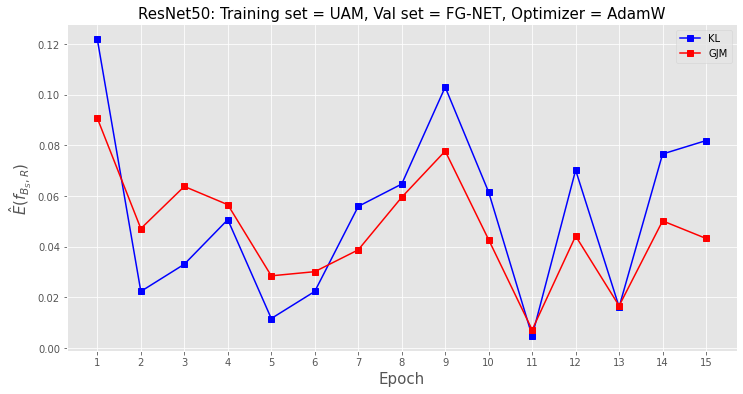

In [20]:
import matplotlib.pyplot as plt



GE_adamw_kl = [0.1217738992878643,
 0.02238558663212764,
 0.033112548308056544,
 0.05070153326253535,
 0.011694266567756628,
 0.022369753333417064,
 0.05591940368516046,
 0.06473934388848046,
 0.10298670115348907,
 0.061534359275110084,
 0.0048070808327291825,
 0.07024418734240423,
 0.016270479987634756,
 0.07659478228149896,
 0.08188908931491601]
 
GE_adamw_gjm = [0.09067628081930024,
 0.04716794189980056,
 0.063797049485259,
 0.0565951457803785,
 0.028535641350438734,
 0.03017261633323043,
 0.038778956935691444,
 0.059525144478313474,
 0.07775416143323355,
 0.04276684138390463,
 0.007216931772168866,
 0.04423283497027308,
 0.016696312383063683,
 0.05020845947555552,
 0.04327644477199455]

plt.style.use('ggplot')
fig1 = plt.figure(figsize=(12,6))
ax = fig1.subplots(1)
ax.plot(range(1,16), GE_adamw_kl, label='KL', c='b', marker='s')
ax.plot(range(1,16), GE_adamw_gjm, label='GJM', c='r', marker='s')
ax.set_xticks(range(1,16))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('$\hat{E}(f_{B_S,R})$', fontsize=15)
ax.set_title("ResNet50: Training set = UAM, Val set = FG-NET, Optimizer = AdamW", fontsize=15)
plt.legend()

## Test on FG-NET

In [10]:
# Evalluation Metrics
def MAE(y_true, y_pred):
   M = y_pred.shape[0]
   return np.sum(np.absolute(y_true - y_pred))/M

def CS(y_true, y_pred):
   M = y_pred.shape[0]
   I = 5
   errors = np.absolute(y_true - y_pred)
   M_I = errors[errors < I].shape[0]
   return M_I/M

In [10]:
X_test_fgnet = X_val
resnet_adamw_kl.eval()
y_pred_adamw_kl = []
with torch.no_grad():
  for i in range(0, X_test_fgnet.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adamw_kl(X_test_fgnet[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adamw_kl += list(pred_indices)

mae_adamw_kl = MAE(y_test, np.array(y_pred_adamw_kl))
cs_adamw_kl = CS(y_test, np.array(y_pred_adamw_kl))
print("ResNet50: Training Set = UAM, optimizer = AdamW, loss=KL")
print("Tested on FG-NET")
print(10*'-')
print("MAE:", mae_adamw_kl)
print("CS:", cs_adamw_kl) 

ResNet50: Training Set = UAM, optimizer = AdamW, loss=KL
Tested on FG-NET
----------
MAE: 5.547904191616767
CS: 0.5449101796407185


In [14]:
X_test_fgnet = X_val

resnet_adamw_gjm.eval()
y_pred_adamw_gjm = []
with torch.no_grad():
  for i in range(0, X_test_fgnet.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adamw_gjm(X_test_fgnet[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adamw_gjm += list(pred_indices)

mae_adamw_gjm = MAE(y_test, np.array(y_pred_adamw_gjm))
cs_adamw_gjm = CS(y_test, np.array(y_pred_adamw_gjm))
print("ResNet50: Training Set = UAM, optimizer = AdamW, loss=GJM")
print("Tested on FG-NET")
print(10*'-')
print("MAE:", mae_adamw_gjm)
print("CS:", cs_adamw_gjm) 

ResNet50: Training Set = UAM, optimizer = AdamW, loss=GJM
Tested on FG-NET
----------
MAE: 5.478043912175648
CS: 0.5489021956087824


## Test on MegaAge-Test

In [11]:
resnet_adamw_kl.eval()
y_pred_adamw_kl = []
with torch.no_grad():
  for i in range(0, X_test_megaage.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adamw_kl(X_test_megaage[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adamw_kl += list(pred_indices)

mae_adamw_kl = MAE(y_test_megaage, np.array(y_pred_adamw_kl))
cs_adamw_kl = CS(y_test_megaage, np.array(y_pred_adamw_kl))
print("ResNet50: Training Set = UAM, optimizer = AdamW, loss=KL")
print("Tested on MegaAge-Test")
print(10*'-')
print("MAE:", mae_adamw_kl)
print("CS:", cs_adamw_kl) 

ResNet50: Training Set = UAM, optimizer = AdamW, loss=KL
Tested on MegaAge-Test
----------
MAE: 6.2276299112801015
CS: 0.5059569074778201


In [15]:
resnet_adamw_gjm.eval()
y_pred_adamw_gjm = []
with torch.no_grad():
  for i in range(0, X_test_megaage.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adamw_gjm(X_test_megaage[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adamw_gjm += list(pred_indices)

mae_adamw_gjm = MAE(y_test_megaage, np.array(y_pred_adamw_gjm))
cs_adamw_gjm = CS(y_test_megaage, np.array(y_pred_adamw_gjm))
print("ResNet50: Training Set = UAM, optimizer = AdamW, loss=GJM")
print("Tested on MegaAge-Test")
print(10*'-')
print("MAE:", mae_adamw_gjm)
print("CS:", cs_adamw_gjm) 

ResNet50: Training Set = UAM, optimizer = AdamW, loss=GJM
Tested on MegaAge-Test
----------
MAE: 6.208111533586819
CS: 0.5158428390367554


## Optimizer: Adam

## KL loss

In [11]:
resnet_adam_kl = create_model()
history_resnet_adam_kl = []
optimizer = Adam(resnet_adam_kl.parameters(), lr=2e-5)
loss_fn = KL
epochs = 15
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss = train(model=resnet_adam_kl, loss_fn = loss_fn, optimizer=optimizer)

    # evaluate model
    val_loss = evaluate(model=resnet_adam_kl, loss_fn=loss_fn)
    print(f'\n\nTraining Loss: {train_loss:.5f}')
    print(f'Val Loss: {val_loss:.5f}')

    history_resnet_adam_kl.append(abs(train_loss-val_loss))

    current = current + 1
    


Epoch 1 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.36398

Training Loss: 2.36527
Val Loss: 2.22423

Epoch 2 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.08064

Training Loss: 2.08189
Val Loss: 2.08765

Epoch 3 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.00137

Training Loss: 2.00256
Val Loss: 1.95520

Epoch 4 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.96388

Training Loss: 1.96498
Val Loss: 1.89992

Epoch 5 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=

### Save The Model

In [26]:
torch.save(resnet_adam_kl.state_dict(), '../checkpoints/ResNet_UAM2/ResNet50_UAM_Adam_Kl.pth')

## GJM loss

In [9]:
resnet_adam_gjm = create_model()
history_resnet_adam_gjm = []
optimizer = Adam(resnet_adam_gjm.parameters(), lr=0.0001)
loss_fn = GJM
epochs = 15
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss = train(model=resnet_adam_gjm, loss_fn = loss_fn, optimizer=optimizer)

    # evaluate model
    val_loss = evaluate(model=resnet_adam_gjm, loss_fn=loss_fn)
    print(f'\n\nTraining Loss: {train_loss:.5f}')
    print(f'Val Loss: {val_loss:.5f}')

    history_resnet_adam_gjm.append(abs(train_loss-val_loss))

    current = current + 1
    


Epoch 1 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.12490

Training Loss: 1.12554
Val Loss: 1.03380

Epoch 2 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.05402

Training Loss: 1.05467
Val Loss: 1.01487

Epoch 3 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.03729

Training Loss: 1.03789
Val Loss: 0.97858

Epoch 4 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.02813

Training Loss: 1.02870
Val Loss: 0.97347

Epoch 5 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=

### Save The Model

In [14]:
torch.save(resnet_adam_gjm.state_dict(), '../checkpoints/ResNet_UAM2/ResNet50_UAM_Adam_GJM.pth')

## Estimated Generalization Error Visualization

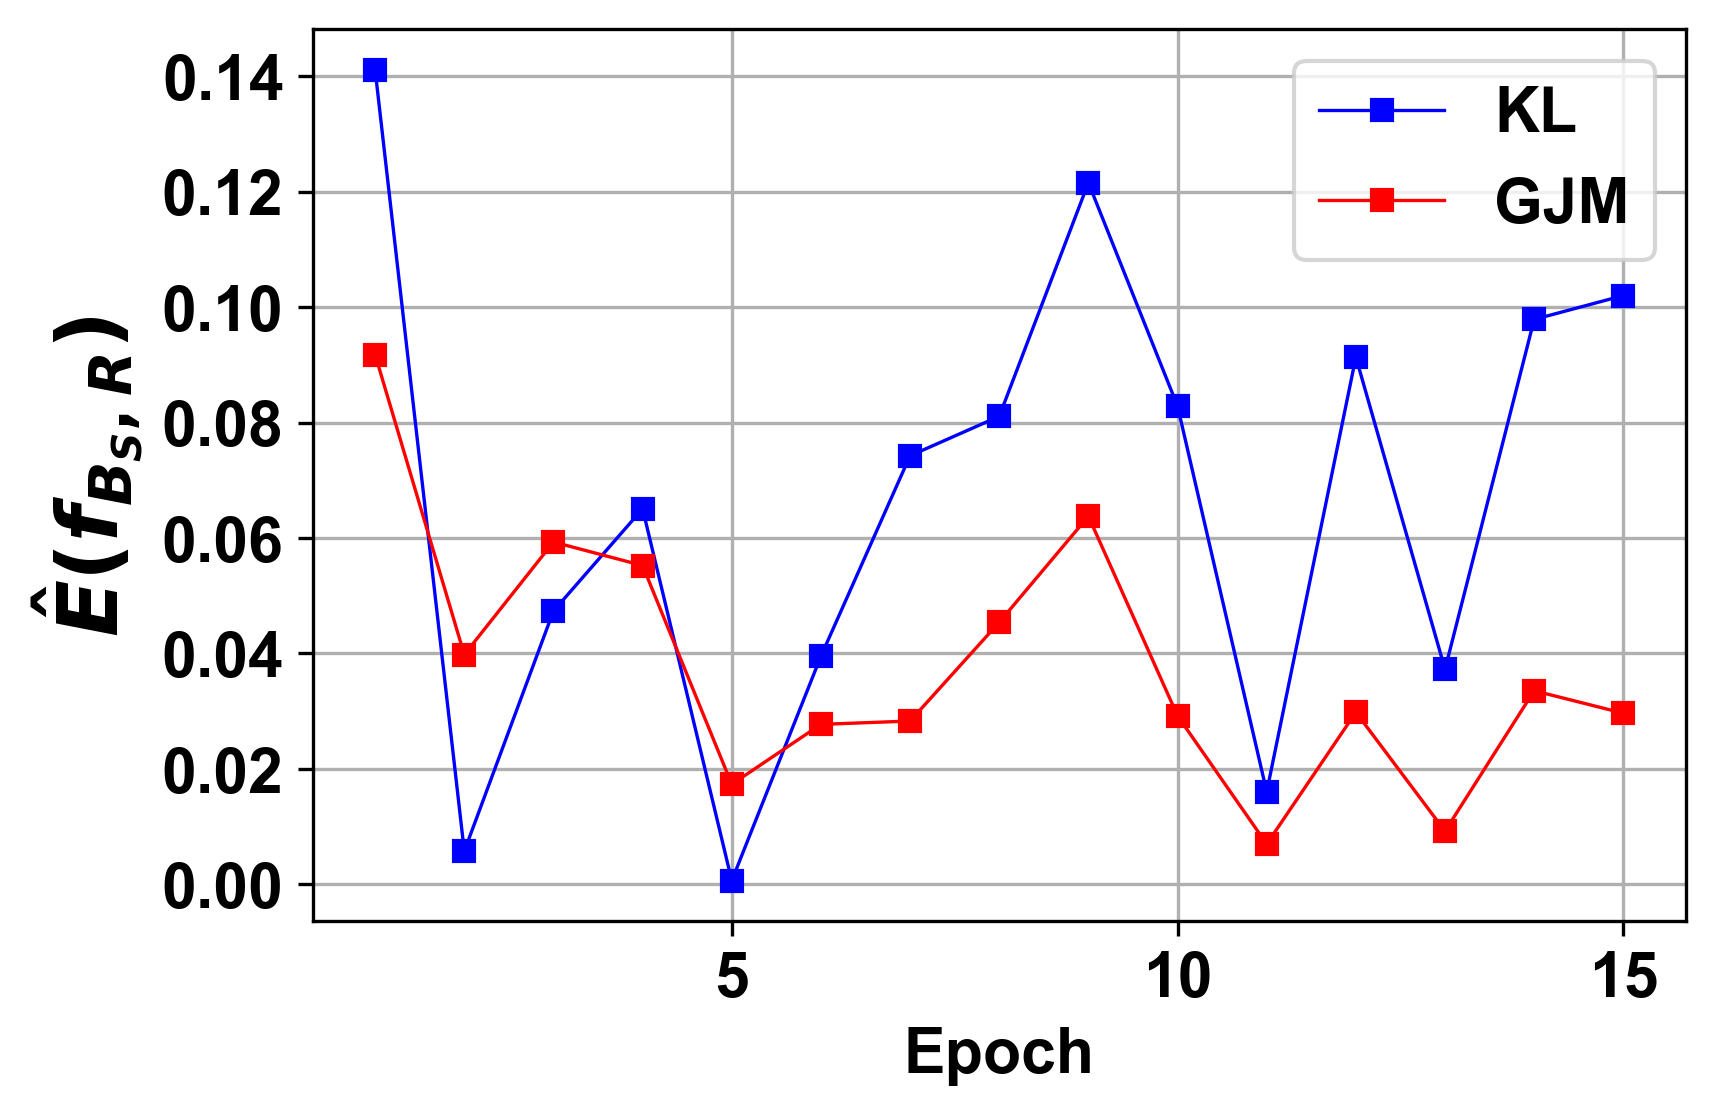

In [12]:
import matplotlib.pyplot as plt


GE_adam_kl = [0.14104852959418768,
 0.005763885634994637,
 0.047358810879603475,
 0.06505930589017717,
 0.0006657720270930589,
 0.03952093781329613,
 0.07424219080173411,
 0.08106753856183224,
 0.12152158144569403,
 0.08282666789997362,
 0.01603740593380598,
 0.09132283977244304,
 0.037261398678760216,
 0.09784724308386239,
 0.1019842757295979]
 
GE_adam_gjm = [0.09173515666508525,
 0.03979861132285656,
 0.0593048493953271,
 0.05522686866987425,
 0.017349631408189126,
 0.027728011087832294,
 0.028302343808767616,
 0.045405307456029886,
 0.06376575383718652,
 0.02920124222140763,
 0.007001589267472075,
 0.029825685965217286,
 0.009234842753231165,
 0.03354942654474158,
 0.02965708491145469]

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
#plt.style.use('ggplot')
cm = 1/2.54
fig1 = plt.figure(figsize=(15*cm,10*cm), dpi=300)
ax = fig1.subplots(1)
ax.plot(range(1,16), GE_adam_kl, label='KL', c='b', marker='s', markersize=5, linewidth = 0.8)
ax.plot(range(1,16), GE_adam_gjm, label='GJM', c='r', marker='s', markersize=5, linewidth = 0.8)
ax.set_xticks(range(5,16,5))

#ax.spines.right.set_visible(False)
#ax.spines.top.set_visible(False)
ax.grid()
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('$\hat{E}(f_{B_S,R})$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.set_title("ResNet50: Training set = UAM, Val set = FG-NET, Optimizer = Adam", fontsize=15)

plt.legend(prop = {'size' : 15})

## Test on FG-NET

In [22]:
X_test_fgnet = X_val
resnet_adam_kl.eval()
y_pred_adam_kl = []
with torch.no_grad():
  for i in range(0, X_test_fgnet.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adam_kl(X_test_fgnet[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adam_kl += list(pred_indices)

mae_adam_kl = MAE(y_test, np.array(y_pred_adam_kl))
cs_adam_kl = CS(y_test, np.array(y_pred_adam_kl))
print("ResNet50: Training Set = UAM, optimizer = Adam, loss=KL")
print("Tested on FG-NET")
print(10*'-')
print("MAE:", mae_adam_kl)
print("CS:", cs_adam_kl) 

ResNet50: Training Set = UAM, optimizer = Adam, loss=KL
Tested on FG-NET
----------
MAE: 5.432135728542915
CS: 0.5508982035928144


In [10]:
X_test_fgnet = X_val

resnet_adam_gjm.eval()
y_pred_adam_gjm = []
with torch.no_grad():
  for i in range(0, X_test_fgnet.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adam_gjm(X_test_fgnet[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adam_gjm += list(pred_indices)

mae_adam_gjm = MAE(y_test, np.array(y_pred_adam_gjm))
cs_adam_gjm = CS(y_test, np.array(y_pred_adam_gjm))
print("ResNet50: Training Set = UAM, optimizer = Adam, loss=GJM")
print("Tested on FG-NET")
print(10*'-')
print("MAE:", mae_adam_gjm)
print("CS:", cs_adam_gjm) 

ResNet50: Training Set = UAM, optimizer = Adam, loss=GJM
Tested on FG-NET
----------
MAE: 5.2684630738522955
CS: 0.5658682634730539


## Test on MegaAge-Test

In [15]:
resnet_adam_kl.eval()
y_pred_adam_kl = []
with torch.no_grad():
  for i in range(0, X_test_megaage.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adam_kl(X_test_megaage[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adam_kl += list(pred_indices)

mae_adam_kl = MAE(y_test_megaage, np.array(y_pred_adam_kl))
cs_adam_kl = CS(y_test_megaage, np.array(y_pred_adam_kl))
print("ResNet50: Training Set = UAM, optimizer = Adam, loss=KL")
print("Tested on MegaAge-Test")
print(10*'-')
print("MAE:", mae_adam_kl)
print("CS:", cs_adam_kl) 

ResNet50: Training Set = UAM, optimizer = Adam, loss=KL
Tested on MegaAge-Test
----------
MAE: 6.283650190114068
CS: 0.49961977186311785


In [11]:
resnet_adam_gjm.eval()
y_pred_adam_gjm = []
with torch.no_grad():
  for i in range(0, X_test_megaage.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_adam_gjm(X_test_megaage[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_adam_gjm += list(pred_indices)

mae_adam_gjm = MAE(y_test_megaage, np.array(y_pred_adam_gjm))
cs_adam_gjm = CS(y_test_megaage, np.array(y_pred_adam_gjm))
print("ResNet50: Training Set = UAM, optimizer = Adam, loss=GJM")
print("Tested on MegaAge-Test")
print(10*'-')
print("MAE:", mae_adam_gjm)
print("CS:", cs_adam_gjm) 

ResNet50: Training Set = UAM, optimizer = Adam, loss=GJM
Tested on MegaAge-Test
----------
MAE: 6.168567807351077
CS: 0.5191381495564005


In [8]:
history_resnet_adamw_kl

[0.1217738992878643,
 0.02238558663212764,
 0.033112548308056544,
 0.05070153326253535,
 0.011694266567756628,
 0.022369753333417064,
 0.05591940368516046,
 0.06473934388848046,
 0.10298670115348907,
 0.061534359275110084,
 0.0048070808327291825,
 0.07024418734240423,
 0.016270479987634756,
 0.07659478228149896,
 0.08188908931491601]

In [16]:
history_resnet_adamw_gjm

[0.09067628081930024,
 0.04716794189980056,
 0.063797049485259,
 0.0565951457803785,
 0.028535641350438734,
 0.03017261633323043,
 0.038778956935691444,
 0.059525144478313474,
 0.07775416143323355,
 0.04276684138390463,
 0.007216931772168866,
 0.04423283497027308,
 0.016696312383063683,
 0.05020845947555552,
 0.04327644477199455]

In [16]:
history_resnet_adam_kl

[0.14104852959418768,
 0.005763885634994637,
 0.047358810879603475,
 0.06505930589017717,
 0.0006657720270930589,
 0.03952093781329613,
 0.07424219080173411,
 0.08106753856183224,
 0.12152158144569403,
 0.08282666789997362,
 0.01603740593380598,
 0.09132283977244304,
 0.037261398678760216,
 0.09784724308386239,
 0.1019842757295979]

In [12]:
history_resnet_adam_gjm

[0.09173515666508525,
 0.03979861132285656,
 0.0593048493953271,
 0.05522686866987425,
 0.017349631408189126,
 0.027728011087832294,
 0.028302343808767616,
 0.045405307456029886,
 0.06376575383718652,
 0.02920124222140763,
 0.007001589267472075,
 0.029825685965217286,
 0.009234842753231165,
 0.03354942654474158,
 0.02965708491145469]

# Optimizer: NovoGrad

## KL loss

In [7]:
from torch_optimizer import NovoGrad
resnet_novograd_kl = create_model()
history_resnet_novograd_kl = []
optimizer = NovoGrad(resnet_novograd_kl.parameters(), lr = 2e-5, weight_decay=0.1)
loss_fn = KL
epochs = 15
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss = train(model=resnet_novograd_kl, loss_fn = loss_fn, optimizer=optimizer)

    # evaluate model
    val_loss = evaluate(model=resnet_novograd_kl, loss_fn=loss_fn)
    print(f'\n\nTraining Loss: {train_loss:.5f}')
    print(f'Val Loss: {val_loss:.5f}')

    history_resnet_novograd_kl.append(abs(train_loss-val_loss))

    current = current + 1
    


Epoch 1 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.84722

Training Loss: 2.84879
Val Loss: 2.86971

Epoch 2 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.63777

Training Loss: 2.63928
Val Loss: 2.79615

Epoch 3 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.57573

Training Loss: 2.57720
Val Loss: 2.75961

Epoch 4 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=2.54890

Training Loss: 2.55040
Val Loss: 2.74820

Epoch 5 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=

### Save The Model

In [22]:
torch.save(resnet_novograd_kl.state_dict(), '../checkpoints/ResNet_UAM2/ResNet50_UAM_NovoGrad_KL.pth')

## GJM loss

In [16]:
resnet_novograd_gjm = create_model()
history_resnet_novograd_gjm = []
optimizer = NovoGrad(resnet_novograd_gjm.parameters(), lr=0.0001, weight_decay=0.1)
loss_fn = GJM
epochs = 15
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss = train(model=resnet_novograd_gjm, loss_fn = loss_fn, optimizer=optimizer)

    # evaluate model
    val_loss = evaluate(model=resnet_novograd_gjm, loss_fn=loss_fn)
    print(f'\n\nTraining Loss: {train_loss:.5f}')
    print(f'Val Loss: {val_loss:.5f}')

    history_resnet_novograd_gjm.append(abs(train_loss-val_loss))

    current = current + 1


Epoch 1 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.34643

Training Loss: 1.34720
Val Loss: 1.40120

Epoch 2 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.30585

Training Loss: 1.30661
Val Loss: 1.39856

Epoch 3 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.30397

Training Loss: 1.30471
Val Loss: 1.39294

Epoch 4 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=1.30433

Training Loss: 1.30509
Val Loss: 1.39038

Epoch 5 / 15:
Batch 1253/1253 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% complete, loss=

### Save The Model

In [21]:
torch.save(resnet_novograd_gjm.state_dict(), '../checkpoints/ResNet_UAM2/ResNet50_UAM_NovoGrad_GJM.pth')

## Estimated Generalization Error Visualization

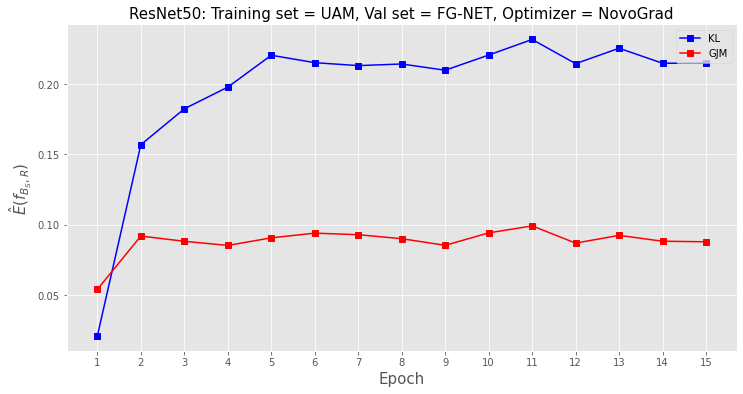

In [25]:
import matplotlib.pyplot as plt


GE_novograd_kl = [0.020922745711976276,
 0.15686887459965604,
 0.18240411690719815,
 0.19780594580278033,
 0.22047372943509957,
 0.21521356039923178,
 0.21310957899166771,
 0.21425907981990733,
 0.20983574565458607,
 0.22060426529659694,
 0.23169670834861833,
 0.21450874252314955,
 0.22545357381894915,
 0.21477418280253913,
 0.21495716483658223]
 
GE_novograd_gjm = [0.05400754686023368,
 0.0919482885445837,
 0.08822481919509206,
 0.08529026276283047,
 0.09068124327446503,
 0.09400583111055605,
 0.09292071323709905,
 0.09006915834193219,
 0.08537283262619089,
 0.09419565519150463,
 0.09916749523148005,
 0.08694239512952096,
 0.09244377876838272,
 0.08827504439218647,
 0.08788707942520313]

plt.style.use('ggplot')
fig1 = plt.figure(figsize=(12,6))
ax = fig1.subplots(1)
ax.plot(range(1,16), GE_novograd_kl, label='KL', c='b', marker='s')
ax.plot(range(1,16), GE_novograd_gjm, label='GJM', c='r', marker='s')
ax.set_xticks(range(1,16))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('$\hat{E}(f_{B_S,R})$', fontsize=15)
ax.set_title("ResNet50: Training set = UAM, Val set = FG-NET, Optimizer = NovoGrad", fontsize=15)
plt.legend()

## Test on FG-NET 

In [11]:
X_test_fgnet = X_val
resnet_novograd_kl.eval()
y_pred_novograd_kl = []
with torch.no_grad():
  for i in range(0, X_test_fgnet.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_novograd_kl(X_test_fgnet[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_novograd_kl += list(pred_indices)

mae_novograd_kl = MAE(y_test, np.array(y_pred_novograd_kl))
cs_novograd_kl = CS(y_test, np.array(y_pred_novograd_kl))
print("ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=KL")
print("Tested on FG-NET")
print(10*'-')
print("MAE:", mae_novograd_kl)
print("CS:", cs_novograd_kl) 

ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=KL
Tested on FG-NET
----------
MAE: 9.599800399201596
CS: 0.2744510978043912


In [19]:
X_test_fgnet = X_val
resnet_novograd_gjm.eval()
y_pred_novograd_gjm = []
with torch.no_grad():
  for i in range(0, X_test_fgnet.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_novograd_gjm(X_test_fgnet[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_novograd_gjm += list(pred_indices)

mae_novograd_gjm = MAE(y_test, np.array(y_pred_novograd_gjm))
cs_novograd_gjm = CS(y_test, np.array(y_pred_novograd_gjm))
print("ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=GJM")
print("Tested on FG-NET")
print(10*'-')
print("MAE:", mae_novograd_gjm)
print("CS:", cs_novograd_gjm) 

ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=GJM
Tested on FG-NET
----------
MAE: 9.363273453093813
CS: 0.2884231536926148


## Test on MegaAge-Test

In [12]:
resnet_novograd_kl.eval()
y_pred_novograd_kl = []
with torch.no_grad():
  for i in range(0, X_test_megaage.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_novograd_kl(X_test_megaage[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_novograd_kl += list(pred_indices)

mae_novograd_kl = MAE(y_test_megaage, np.array(y_pred_novograd_kl))
cs_novograd_kl = CS(y_test_megaage, np.array(y_pred_novograd_kl))
print("ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=KL")
print("Tested on MegaAge-Test")
print(10*'-')
print("MAE:", mae_novograd_kl)
print("CS:", cs_novograd_kl) 

ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=KL
Tested on MegaAge-Test
----------
MAE: 8.385804816223068
CS: 0.43041825095057035


In [20]:
resnet_novograd_gjm.eval()
y_pred_novograd_gjm = []
with torch.no_grad():
  for i in range(0, X_test_megaage.size()[0], 100):
    gc.collect()
    torch.cuda.empty_cache()
    preds = resnet_novograd_gjm(X_test_megaage[i:i+100].to(device))
    preds = preds.detach().cpu().numpy()
    pred_indices = preds.argmax(axis=1)
    y_pred_novograd_gjm += list(pred_indices)

mae_novograd_gjm = MAE(y_test_megaage, np.array(y_pred_novograd_gjm))
cs_novograd_gjm = CS(y_test_megaage, np.array(y_pred_novograd_gjm))
print("ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=GJM")
print("Tested on MegaAge-Test")
print(10*'-')
print("MAE:", mae_novograd_gjm)
print("CS:", cs_novograd_gjm) 

ResNet50: Training Set = UAM, optimizer = NovoGrad, loss=GJM
Tested on MegaAge-Test
----------
MAE: 8.636755386565273
CS: 0.4217997465145754


In [8]:
history_resnet_novograd_kl

[0.020922745711976276,
 0.15686887459965604,
 0.18240411690719815,
 0.19780594580278033,
 0.22047372943509957,
 0.21521356039923178,
 0.21310957899166771,
 0.21425907981990733,
 0.20983574565458607,
 0.22060426529659694,
 0.23169670834861833,
 0.21450874252314955,
 0.22545357381894915,
 0.21477418280253913,
 0.21495716483658223]

In [17]:
history_resnet_novograd_gjm

[0.05400754686023368,
 0.0919482885445837,
 0.08822481919509206,
 0.08529026276283047,
 0.09068124327446503,
 0.09400583111055605,
 0.09292071323709905,
 0.09006915834193219,
 0.08537283262619089,
 0.09419565519150463,
 0.09916749523148005,
 0.08694239512952096,
 0.09244377876838272,
 0.08827504439218647,
 0.08788707942520313]